In [5]:
create_tokenizedDF= False
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import nltk
from numpy import trapz
from scipy.signal import find_peaks

stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
snowball = nltk.stem.snowball.SnowballStemmer('portuguese')
right=[ 'PSD',  'CDS-PP', 'CH','IL','CDS']
left=[ 'PS', 'BE', 'PCP', 'PAN', 'PEV','L']

In [6]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
         
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def create_tokenized_dataset(df_input):
    # 1 create token column: tokens
    df_input['tokens']=df_input['speech'].apply(lambda x: nltk.word_tokenize(x))
    # 2 create token without stopwords and stemmer: tokens_stemer_stop. 16min
    df_input['tokens_stemer_stop'] = df_input['tokens'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
    
    # 3 extract very frequent or rare words: token_cleaned
    flat_tokens=[item for sublist in df_input['tokens_stemer_stop'] for item in sublist]
    aux_c=Counter(flat_tokens)
        
    extrat_common=['par', 'nao', 'sr', 'deput', 'govern', 'muit', 'pel', 'president','tod','tamb','srs','sras','pod','part','psd','sao','aplaus','ja','porqu','faz','ha','diz','quer','pais','sobr','bem','nest']
    extract_rare=[x[0] for x in aux_c.most_common()[-30:]]

    df_input['tokens_cleaned'] = df_input['tokens_stemer_stop'].apply(lambda x : [i for i in x if not i in extrat_common])
    df_input['tokens_cleaned'] = df_input['tokens_cleaned'].apply(lambda x : [i for i in x if not i in extract_rare])
    df_input.to_pickle('dftok.pkl')  
    return df_input

def generate_N_grams(text,ngram=1):
  words=[word for word in text]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

def create_grams(df_frame, n):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
    df_frame[grams_d[n]] = df_frame['tokens_cleaned'].apply(lambda x: generate_N_grams(x,n))
    return df_frame 

#political polarization functions




def create_frequency_table_grams(n_gram=1, indf=None, right_parties=right, left_parties=left):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
   

    r_grams=[item for sublist in indf[indf.party.isin(right)][grams_d[n_gram]] for item in sublist]
    l_grams=[item for sublist in indf[indf.party.isin(left)][grams_d[n_gram]] for item in sublist]

    total_counter = Counter([item for sublist in indf[grams_d[n_gram]] for item in sublist])
    right_counter = Counter(r_grams)
    left_counter = Counter(l_grams)

    df_all = pd.DataFrame.from_dict(total_counter, orient='index').reset_index()
    df_all.columns=['phrase','count']
    df_all['count_right']=[right_counter[x] for x in df_all.phrase]
    df_all['count_left']=[left_counter[x] for x in df_all.phrase]


    df_all['count_left_total']=sum(left_counter.values())
    df_all['count_right_total']=sum(right_counter.values())
    # frequency of every words except the given one (by row)
    #Jensen et al. (2012),p.10 
    #f-pck is the frequency of all phrases used in Con­gress c by party k excluding phrase p
    df_all['f_right_minus']=( df_all['count_right_total']-df_all['count_right'])/df_all['count_right_total']
    df_all['f_left_minus']=( df_all['count_left_total']-df_all['count_left'])/df_all['count_left_total']

    df_all['f_right']=df_all['count_right']/df_all['count_right_total']
    df_all['f_right_norm'] = (df_all['f_right'] - df_all['f_right'].min()) / (df_all['f_right'].max() - df_all['f_right'].min())  
    df_all['f_left']=df_all['count_left']/df_all['count_left_total']
    df_all['f_left_norm'] = (df_all['f_left'] - df_all['f_left'].min()) / (df_all['f_left'].max() - df_all['f_left'].min())  

    df_all['f_right_minus_norm']=(df_all['f_right_minus'] - df_all['f_right_minus'].min()) / (df_all['f_right_minus'].max() - df_all['f_right_minus'].min()) 
    df_all['f_left_minus_norm']=(df_all['f_left_minus'] - df_all['f_left_minus'].min()) / (df_all['f_left_minus'].max() - df_all['f_left_minus'].min()) 

    return df_all


def calculate_pearson(df_all):
    aa=df_all['f_right_norm']*df_all['f_left_minus_norm'] 
    bb=df_all['f_left_norm']*df_all['f_right_minus_norm']
    cc=aa-bb
    dd=cc*cc
    d11=df_all['f_right_norm']+df_all['f_left_norm']
    d22=df_all['f_right_norm']+df_all['f_right_minus_norm']
    d33=df_all['f_left_norm']+df_all['f_left_minus_norm']
    d44=df_all['f_right_minus_norm']+df_all['f_left_minus_norm']
    denom=d11*d22*d33*d44
    pp=dd/denom
    return pp

def create_phrase_partisanship(df):
    aa=df['f_right_norm']+df['f_left_norm']
    df['rho']=df['f_right_norm']/aa
    
    df['gram_partisanship']= 0.5 * df['f_right_norm']*df['rho']+0.5 *df['f_right_norm']*(1-df['rho'])
    
    return df

def create_polarization_correlation(df):
    
    aa=df['f_left_norm']*-1
    bb= df['f_right_norm']*1
    df['beta_polarization']=aa+bb

    return df

def partisanship_by_speach(df_in,partisan_dict, new_column='partisanship', ngrams_col='tri_grams'):
    df_in[new_column] = [np.empty(0,dtype=float)]*len(df_in)
    df_in[new_column] =df_in[new_column].astype(object)
    out_res=[]
    for n,row in enumerate(df_in[ngrams_col]):
    
        res=[]
        for x in row:
            
            if x in partisan_dict:
                res.append( partisan_dict[x])
            
            else:
                res.append( 0)
        out_res.append(res)
    df_in[new_column]=out_res
    return df_in

def create_200r(df_mainf):
    indexes_no_applause=[n for n,x in enumerate(df_mainf.phrase) if 'aplausos' not in x]
    df_mainf=df_mainf.iloc[indexes_no_applause]

    tri_final = df_mainf[0:200].append(df_mainf[-200:], ignore_index=True)
    return tri_final


def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return  idx

In [7]:
# load dataframe
if create_tokenizedDF==True:
    df_input = pd.read_pickle('parliament_fdf.pkl')  
    df_tok=create_tokenized_dataset(df_input)
else:
    df_tok = pd.read_pickle('dftok.pkl')  
    

In [8]:
# 1 Create n-grams
#df_tok=create_grams(df_tok, 2)
df_tok=create_grams(df_tok, 3)

In [9]:
# 2 create frequency table
df_freq=create_frequency_table_grams(n_gram=3, indf=df_tok, right_parties=right, left_parties=left)
# 3 Filter pearson >0
df_freq['pearson_quad']=calculate_pearson(df_freq)
trigrams_table=df_freq[df_freq.pearson_quad>0]
#  4 Add  partisanship by word
trigrams_table=create_phrase_partisanship(trigrams_table)
trigrams_table=create_polarization_correlation(trigrams_table)
trigrams_table=trigrams_table.sort_values(by='gram_partisanship',ascending=False)


In [10]:
# 5 Dictionary of trigrams and partisanship
partisan_dict=dict(zip(trigrams_table.phrase,trigrams_table.gram_partisanship))

In [11]:
# 6 Partisanship by speach
df_tok=partisanship_by_speach(df_in=df_tok, new_column='partisanship', ngrams_col='tri_grams',partisan_dict=partisan_dict)
df_tok['avg_partisanship']=df_tok.partisanship.apply(lambda x: sum(x))

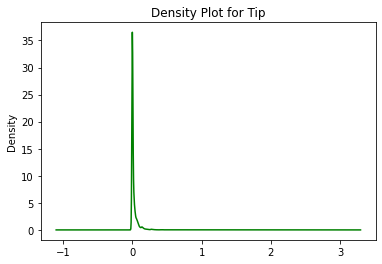

In [14]:
df_tok.head(5)
import seaborn as sns
import matplotlib.pyplot as plt
df_tok['avg_partisanship'].plot.density(color='green')
plt.title('Density Plot for Tip')
plt.show()


C:\Users\trind\AppData\Local\Temp\ipykernel_16260\793341432.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)


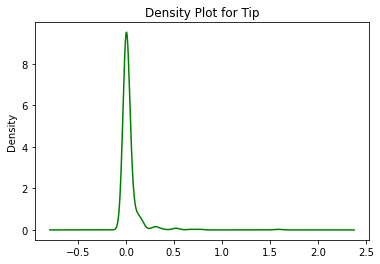

In [15]:
tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)
tri_final['avg_partisanship'].plot.density(color='green')
plt.title('Density Plot for Tip')
plt.show()

In [21]:
df_tok.sort_values("avg_partisanship", axis =0, ascending = False,inplace = True)
tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)

C:\Users\trind\AppData\Local\Temp\ipykernel_16260\3479927013.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)


In [142]:
tri_final.year.unique()

array([2018, 2017, 2021, 2020, 2019, 2016], dtype=int64)

In [237]:
YEAR_S=2018

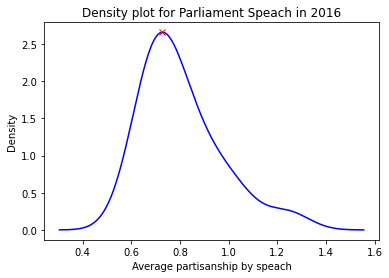

0.7963331523460946 0


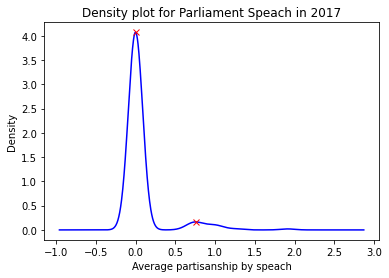

1o 0.9212949683295211 0.0667097561290795


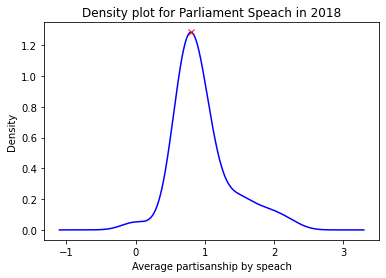

0.9259059475548395 0


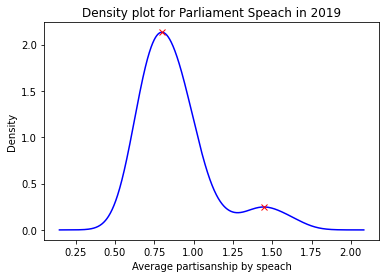

1o 0.869321273013123 0.12793056049954568


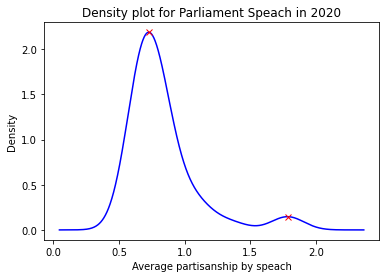

1o 0.9257688615171447 0.07379755290802323


<Figure size 432x288 with 0 Axes>

In [242]:
# 
df_polmetric=pd.DataFrame([])

for YEAR_S in range(2016, 2021):
    res=[]
    tri_final[tri_final.year==YEAR_S]['avg_partisanship'].plot.density(color='blue')
    plt.title('Density plot for Parliament Speach in '+ str(YEAR_S))
    plt.xlabel('Average partisanship by speach')
    line = plt.gca().get_lines()
    x_data = line[0].get_data()[0]
    y1_data = line[0].get_data()[1]
    peaks, _ = find_peaks(y1_data, height=0)
    plt.plot(x_data[peaks[0]],y1_data[peaks[0]], "x", color='red')
    if len(peaks)>1:
        plt.plot(x_data[peaks[1]],y1_data[peaks[1]], "x", color='red')

    plt.show()
    plt.clf()
    if len(peaks)>1:
        #distance_from_peaks=x_data[peaks[0]]

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)
        #print(fstartY,fendY)
        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        second_peak_start=first_peak_endX
        SstartY=find_nearest_idx(x_data, second_peak_start)
        second_peak_end=x_data[peaks[1]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        SendY=find_nearest_idx(x_data, second_peak_end)


        area_right = trapz(y1_data[SstartY:SendY], x_data[SstartY:SendY],dx=1)

        print('1o', area_left,area_right)
    else:
        distance_from_peaks=min(x_data[:peaks[0]])

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)

        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[0]]-x_data[0])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        area_right=0
        print(area_left,area_right)

    res.append(YEAR_S)
    if len(peaks)>1:
        res.append(x_data[peaks[1]]-x_data[peaks[0]]) #partisanship_interval
    else:
        res.append(0)
    res.append(area_left)
    res.append( area_right)

    new_df = pd.DataFrame([res])
    df_polmetric = pd.concat([df_polmetric, new_df], axis=0, ignore_index=True)
    

In [243]:
df_polmetric.columns='year','partisanship_interval', 'left_probability','right_probability'
df_polmetric

,year,partisanship_interval,left_probability,right_probability
0,2016,0.000000,0.796333,0.000000
1,2017,0.754615,0.921295,0.066710
2,2018,0.000000,0.925906,0.000000
3,2019,0.648760,0.869321,0.127931
4,2020,1.058149,0.925769,0.073798


In [ ]:
#graficos tabela
#graficos porlegislatura